# Operations on a Computational Graph

We start by loading the necessary libraries and resetting the computational graph.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Start a graph session

In [2]:
sess = tf.Session()

### Create tensors

In [3]:
# Create data to feed in the placeholder
x_vals = np.array([1., 3., 5., 7., 9.])

# Create the TensorFlow Placceholder
x_data = tf.placeholder(tf.float32)

# Constant for multilication
m = tf.constant(3.)

We loop through the input values and print out the multiplication operation for each input.

In [4]:
# Multiplication
prod = tf.multiply(x_data, m)
for x_val in x_vals:
    print(sess.run(prod, feed_dict={x_data: x_val}))

3.0
9.0
15.0
21.0
27.0


### Output graph to Tensorboard

In [5]:
merged = tf.summary.merge_all(key='summaries')
if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')

my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)

![Operations on a Graph](https://github.com/nfmcclure/tensorflow_cookbook/raw/master/02_TensorFlow_Way/images/01_Operations_on_a_Graph.png)

---

# Layering Nested Operations

We start by loading the necessary libraries and resetting the computational graph.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Create a graph session

In [7]:
sess = tf.Session()

### Create the Tensors, Constants, and Placeholders

We start by creating an array to feed in to a placeholder (note the agreements on the dimensions).  We then declare some graph constants to use in the operations.

In [8]:
# Create data to feed in
my_array = np.array([[1., 3., 5., 7., 9.],
                   [-2., 0., 2., 4., 6.],
                   [-6., -3., 0., 3., 6.]])
# Duplicate the array for having two inputs
x_vals = np.array([my_array, my_array + 1])
# Declare the placeholder
x_data = tf.placeholder(tf.float32, shape=(3, 5))
# Declare constants for operations
m1 = tf.constant([[1.],[0.],[-1.],[2.],[4.]])
m2 = tf.constant([[2.]])
a1 = tf.constant([[10.]])

### Declare Operations

We start with matrix multiplication (A[3x5] * m1[5x1]) = prod1[3x1]

In [9]:
# 1st Operation Layer = Multiplication
prod1 = tf.matmul(x_data, m1)

Second operation is multiplication of prod1[3x1] by m2[1x1], which results in prod2[3x1]

In [10]:
# 2nd Operation Layer = Multiplication
prod2 = tf.matmul(prod1, m2)

The third operation is matrix addition of prod2[3x1] to a1[1x1], This makes use of TensorFlow's broadcasting.

In [11]:
# 3rd Operation Layer = Addition
add1 = tf.add(prod2, a1)

### Evaluate and Print Output

In [12]:
for x_val in x_vals:
    print(sess.run(add1, feed_dict={x_data: x_val}))

[[ 102.]
 [  66.]
 [  58.]]
[[ 114.]
 [  78.]
 [  70.]]


### Create and Format Tensorboard outputs for viewing

In [13]:
merged = tf.summary.merge_all(key='summaries')

if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')

my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)

![layering_nested_operations](https://github.com/nfmcclure/tensorflow_cookbook/raw/master/02_TensorFlow_Way/images/02_Multiple_Operations.png)

---

# Working With Multiple Layers

First we start with loading the necessary libraries and resetting the computational graph.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Create a Graph Session

In [15]:
sess = tf.Session()

### Create Tensors

Here we will create a small image of size 4x4 pixels and propagate it through multiple layers.

In [16]:
# Create a small random 'image' of size 4x4
x_shape = [1, 4, 4, 1]
x_val = np.random.uniform(size=x_shape)

### Create the Data Placeholder

In [17]:
x_data = tf.placeholder(tf.float32, shape=x_shape)

### First Layer: Moving Window (Convolution)

Our first layer will be a spatial moving window of size [2x2] with stride 2 (in both height and width directions)

To make this a moving window average, the value of the filter will be all 0.25.

In [18]:
# Create a layer that takes a spatial moving window average
# Our window will be 2x2 with a stride of 2 for height and width
# The filter value will be 0.25 because we want the average of the 2x2 window
my_filter = tf.constant(0.25, shape=[2, 2, 1, 1])
my_strides = [1, 2, 2, 1]
mov_avg_layer= tf.nn.conv2d(x_data, my_filter, my_strides,
                            padding='SAME', name='Moving_Avg_Window')

### Second Layer: Custom

Our second layer will be a custom layer.  Given an input, x, this layer flattens out x and computes sigmoid(Ax+b).  Here, A and b will be predetermined constants.

We then add the custom layer to the graph under the name 'Custom_Layer'.  This is for visualizing the graph in Tensorboard later.

In [19]:
# Define a custom layer which will be sigmoid(Ax+b) where
# x is a 2x2 matrix and A and b are 2x2 matrices
def custom_layer(input_matrix):
    input_matrix_sqeezed = tf.squeeze(input_matrix)
    A = tf.constant([[1., 2.], [-1., 3.]])
    b = tf.constant(1., shape=[2, 2])
    temp1 = tf.matmul(A, input_matrix_sqeezed)
    temp = tf.add(temp1, b) # Ax + b
    return(tf.sigmoid(temp))

# Add custom layer to graph
with tf.name_scope('Custom_Layer') as scope:
    custom_layer1 = custom_layer(mov_avg_layer)

### Run Output

The output should be an array that is 2x2, but size (1,2,2,1)

In [20]:
print(sess.run(mov_avg_layer, feed_dict={x_data: x_val}))

[[[[ 0.40801105]
   [ 0.76181149]]

  [[ 0.44685942]
   [ 0.38857445]]]]


After custom operation, size is now 2x2 (squeezed out size 1 dims), see below:

In [21]:
print(sess.run(custom_layer1, feed_dict={x_data: x_val}))

[[ 0.90902025  0.92682838]
 [ 0.87353325  0.80280393]]


Save summaries for viewing in Tensorboard:

In [22]:
merged = tf.summary.merge_all(key='summaries')

if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')

my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)

![multiple_layers_tensorboard](https://github.com/nfmcclure/tensorflow_cookbook/raw/master/02_TensorFlow_Way/images/03_Multiple_Layers.png)

---

# Loss Functions

This python script illustrates the different loss functions for regression and classification.

We start by loading the ncessary libraries and resetting the computational graph.

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Create a Graph Session

In [24]:
sess = tf.Session()

## Numerical Predictions

---------------------------------

To start with our investigation of loss functions, we begin by looking at numerical loss functions.  To do so, we must create a sequence of predictions around a target.  For this exercise, we consider the target to be zero.

In [25]:
# Various Predicted X-values
x_vals = tf.linspace(-1., 1., 500)

# Create our target of zero
target = tf.constant(0.)

### L2 Loss

The L2 loss is one of the most common regression loss functions.  Here we show how to create it in TensorFlow and we evaluate it for plotting later.

In [26]:
# L2 loss
# L = (pred - actual)^2
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)

### L1 Loss

An alternative loss function to consider is the L1 loss. This is very similar to L2 except that we take the `absolute value` of the difference instead of squaring it.

In [27]:
# L1 loss
# L = abs(pred - actual)
l1_y_vals = tf.abs(target - x_vals)
l1_y_out = sess.run(l1_y_vals)

### Pseudo-Huber Loss

The psuedo-huber loss function is a smooth approximation to the L1 loss as the (predicted - target) values get larger.  When the predicted values are close to the target, the pseudo-huber loss behaves similar to the L2 loss.

In [28]:
# L = delta^2 * (sqrt(1 + ((pred - actual)/delta)^2) - 1)

# Pseudo-Huber with delta = 0.25
delta1 = tf.constant(0.25)
phuber1_y_vals = tf.multiply(tf.square(delta1), tf.sqrt(1. + tf.square((target - x_vals)/delta1)) - 1.)
phuber1_y_out = sess.run(phuber1_y_vals)

# Pseudo-Huber with delta = 5
delta2 = tf.constant(5.)
phuber2_y_vals = tf.multiply(tf.square(delta2), tf.sqrt(1. + tf.square((target - x_vals)/delta2)) - 1.)
phuber2_y_out = sess.run(phuber2_y_vals)

### Plot the Regression Losses

Here we use Matplotlib to plot the L1, L2, and Pseudo-Huber Losses.

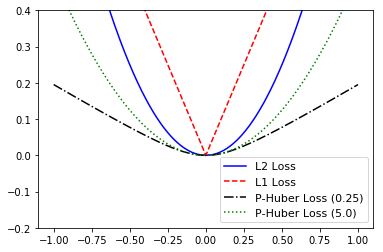

In [29]:
x_array = sess.run(x_vals)
plt.plot(x_array, l2_y_out, 'b-', label='L2 Loss')
plt.plot(x_array, l1_y_out, 'r--', label='L1 Loss')
plt.plot(x_array, phuber1_y_out, 'k-.', label='P-Huber Loss (0.25)')
plt.plot(x_array, phuber2_y_out, 'g:', label='P-Huber Loss (5.0)')
plt.ylim(-0.2, 0.4)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

## Categorical Predictions

-------------------------------

We now consider categorical loss functions.  Here, the predictions will be around the target of 1.

In [30]:
# Various predicted X values
x_vals = tf.linspace(-3., 5., 500)

# Target of 1.0
target = tf.constant(1.)
targets = tf.fill([500,], 1.)

### Hinge Loss

The hinge loss is useful for categorical predictions.  Here is is the `max(0, 1-(pred*actual))`.

In [31]:
# Hinge loss
# Use for predicting binary (-1, 1) classes
# L = max(0, 1 - (pred * actual))
hinge_y_vals = tf.maximum(0., 1. - tf.multiply(target, x_vals))
hinge_y_out = sess.run(hinge_y_vals)

### Cross Entropy Loss

The cross entropy loss is a very popular way to measure the loss between categorical targets and output model logits.  You can read about the details more here: https://en.wikipedia.org/wiki/Cross_entropy

In [32]:
# Cross entropy loss
# L = -actual * (log(pred)) - (1-actual)(log(1-pred))
xentropy_y_vals = - tf.multiply(target, tf.log(x_vals)) - tf.multiply((1. - target), tf.log(1. - x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)

### Sigmoid Entropy Loss

TensorFlow also has a sigmoid-entropy loss function.  This is very similar to the above cross-entropy function except that we take the sigmoid of the predictions in the function.

In [33]:
# L = -actual * (log(sigmoid(pred))) - (1-actual)(log(1-sigmoid(pred)))
# or
# L = max(actual, 0) - actual * pred + log(1 + exp(-abs(actual)))
x_val_input = tf.expand_dims(x_vals, 1)
target_input = tf.expand_dims(targets, 1)
xentropy_sigmoid_y_vals = tf.nn.softmax_cross_entropy_with_logits(logits=x_val_input, labels=target_input)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)

### Weighted (Softmax) Cross Entropy Loss

Tensorflow also has a similar function to the `sigmoid cross entropy` loss function above, but we take the softmax of the actuals and weight the predicted output instead.

In [34]:
# Weighted (softmax) cross entropy loss
# L = -actual * (log(pred)) * weights - (1-actual)(log(1-pred))
# or
# L = (1 - pred) * actual + (1 + (weights - 1) * pred) * log(1 + exp(-actual))
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(x_vals, targets, weight)
xentropy_weighted_y_out = sess.run(xentropy_weighted_y_vals)

### Plot the Categorical Losses

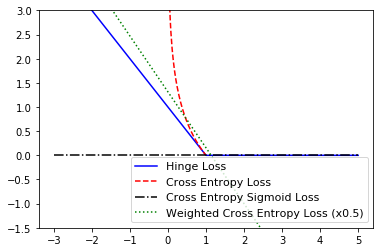

In [35]:
# Plot the output
x_array = sess.run(x_vals)
plt.plot(x_array, hinge_y_out, 'b-', label='Hinge Loss')
plt.plot(x_array, xentropy_y_out, 'r--', label='Cross Entropy Loss')
plt.plot(x_array, xentropy_sigmoid_y_out, 'k-.', label='Cross Entropy Sigmoid Loss')
plt.plot(x_array, xentropy_weighted_y_out, 'g:', label='Weighted Cross Entropy Loss (x0.5)')
plt.ylim(-1.5, 3)
#plt.xlim(-1, 3)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

### Softmax entropy and Sparse Entropy

Since it is hard to graph mutliclass loss functions, we will show how to get the output instead

In [36]:
# Softmax entropy loss
# L = -actual * (log(softmax(pred))) - (1-actual)(log(1-softmax(pred)))
unscaled_logits = tf.constant([[1., -3., 10.]])
target_dist = tf.constant([[0.1, 0.02, 0.88]])
softmax_xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=unscaled_logits,
                                                           labels=target_dist)
print(sess.run(softmax_xentropy))

# Sparse entropy loss
# Use when classes and targets have to be mutually exclusive
# L = sum( -actual * log(pred) )
unscaled_logits = tf.constant([[1., -3., 10.]])
sparse_target_dist = tf.constant([2])
sparse_xentropy =  tf.nn.sparse_softmax_cross_entropy_with_logits(logits=unscaled_logits,
                                                                  labels=sparse_target_dist)
print(sess.run(sparse_xentropy))

[ 1.16012561]
[ 0.00012564]


# Implementing Back Propagation

For this recipe, we will show how to do TWO separate examples, a regression example, and a classification example.

To illustrate how to do back propagation with TensorFlow, we start by loading the necessary libraries and resetting the computational graph.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Create a Graph Session

In [38]:
sess = tf.Session()

## A Regression Example

------------------------------

We create a regression example as follows.  The input data will be 100 random samples from a normal (mean of 1.0, stdev of 0.1).  The target will be 100 constant values of 10.0.

We will fit the regression model:  `x_data * A = target_values`

Theoretically, we know that A should be equal to 10.0.

We start by creating the data and targets with their respective placholders

In [39]:
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[1], dtype=tf.float32)
y_target = tf.placeholder(shape=[1], dtype=tf.float32)

We now create the variable for our computational graph, `A`.

In [40]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1]))

We add the model operation to the graph.  This is just multiplying the input data by A to get the output.

In [41]:
# Add operation to graph
my_output = tf.multiply(x_data, A)

Next we have to specify the loss function.  This will allow TensorFlow to know how to change the model variables.  We will use the L2 loss function here.  Note: to use the L1 loss function, change `tf.square()` to `tf.abs()`.

In [42]:
# Add L2 loss operation to graph
loss = tf.square(my_output - y_target)

Now we initialize all our variables.  For specificity here, this is initializing the variable `A` on our graph with a random standard normal number.

In [43]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

We need to create an optimizing operations.  Here we use the standard `GradientDescentOptimizer()`, and tell TensorFlow to minimize the loss.  Here we use a learning rate of `0.02`, but feel free to experiment around with this rate, and see the learning curve at the end.  However, note that learning rates that are too large will result in the algorithm not converging.

In [44]:
# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

### Running the Regression Graph!

Here we will run the regression computational graph for 100 iterations, printing out the A-value and loss every 25 iterations.  We should see the value of A get closer and closer to the true value of 10, as the loss goes down.

In [45]:
# Run Loop
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%25==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #25 A = [ 6.59285593]
Loss = [ 7.60028887]
Step #50 A = [ 8.70938778]
Loss = [ 1.35410917]
Step #75 A = [ 9.3281908]
Loss = [ 0.00364148]
Step #100 A = [ 9.61360741]
Loss = [ 0.16839404]


## Classification Example

--------------------

For the classification example, we will create an x-sample made of two different normal distribution inputs, `Normal(mean = -1, sd = 1)` and `Normal(mean = 3, sd = 1)`.  For each of these the target will be the class `0` or `1` respectively.

The model will fit the binary classification:  If `sigmoid(x+A) < 0.5` then predict class `0`, else class `1`.

Theoretically, we know that `A` should take on the value of the negative average of the two means: `-(mean1 + mean2)/2`.

We start by resetting the computational graph:

In [46]:
ops.reset_default_graph()

Start a graph session

In [47]:
# Create graph
sess = tf.Session()

We generate the data that we will feed into the graph.  Note that the `x_vals` are the combination of two separate normals, and the y_vals are the combination of two separate constants (two classes).

We also create the relevant placeholders for the model.

In [48]:
# Create data
x_vals = np.concatenate((np.random.normal(-1, 1, 50), np.random.normal(3, 1, 50)))
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50)))
x_data = tf.placeholder(shape=[1], dtype=tf.float32)
y_target = tf.placeholder(shape=[1], dtype=tf.float32)

We now create the one model variable, used for classification.  We also set the initialization function, a random normal, to have a mean far from the expected theoretical value.

- Initialized to be around 10.0
- Theoretically around -1.0

In [49]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(mean=10, shape=[1]))

Now we add the model operation to the graph.  This will be the adding of the variable `A` to the data.  Note that the `sigmoid()` is left out of this operation, because we will use a loss function that has it built in.

We also have to add the batch dimension to each of the target and input values to use the built in functions.

In [50]:
# Add operation to graph
# Want to create the operstion sigmoid(x + A)
# Note, the sigmoid() part is in the loss function
my_output = tf.add(x_data, A)

# Now we have to add another dimension to each (batch size of 1)
my_output_expanded = tf.expand_dims(my_output, 0)
y_target_expanded = tf.expand_dims(y_target, 0)

Add classification loss (cross entropy)

In [51]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output_expanded, labels=y_target_expanded)

Now we declare the optimizer function.  Here we will be using the standard gradient descent operator with a learning rate of `0.05`.

In [52]:
# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

Next we create an operation to initialize the variables and then run that operation

In [53]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Running the Classification Graph!

Now we can loop through our classification graph and print the values of A and the loss values.

In [54]:
# Run loop
for i in range(1400):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #200 A = [ 4.22674227]
Loss = [[ 1.68538833]]
Step #400 A = [ 0.66219682]
Loss = [[ 0.28871155]]
Step #600 A = [-0.60139632]
Loss = [[ 0.05338944]]
Step #800 A = [-0.77048737]
Loss = [[ 0.28615654]]
Step #1000 A = [-0.92154956]
Loss = [[ 0.04464305]]
Step #1200 A = [-1.05341911]
Loss = [[ 0.13927068]]
Step #1400 A = [-1.11017537]
Loss = [[ 0.08744667]]


Now we can also see how well we did at predicting the data by creating an accuracy function and evaluating them on the known targets.

In [55]:
# Evaluate Predictions
predictions = []
for i in range(len(x_vals)):
    x_val = [x_vals[i]]
    prediction = sess.run(tf.round(tf.sigmoid(my_output)), feed_dict={x_data: x_val})
    predictions.append(prediction[0])
    
accuracy = sum(x==y for x,y in zip(predictions, y_vals))/100.
print('Ending Accuracy = ' + str(np.round(accuracy, 2)))

Ending Accuracy = 0.96


# Batch and Stochastic Training

This python function illustrates two different training methods: batch and stochastic training.  For each model, we will use a regression model that predicts one model variable.

We start by loading the necessary libraries and resetting the computational graph.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

We start a computational graph session.

In [57]:
sess = tf.Session()

# Stochastic Training

----------------------

### Generate Data

The data we will create is 100 random samples from a `Normal(mean = 1, sd = 0.1)`.  The target will be an array of size 100 filled with the constant 10.0.

We also create the necessary placeholders in the graph for the data and target.  Note that we use a shape of `[1]` for stochastic training.

In [58]:
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)

x_data = tf.placeholder(shape=[1], dtype=tf.float32)
y_target = tf.placeholder(shape=[1], dtype=tf.float32)

### Model Variables and Operations

We create the one variable in the graph, `A`.  We then create the model operation, which is just the multiplication of the input data and `A`.

In [59]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1]))

# Add operation to graph
my_output = tf.multiply(x_data, A)

### Loss Function

For this, we choose the L2 loss.  We can easily choose the L1 loss by replacing `tf.square()` with `tf.abs()`.

In [60]:
# Add L2 loss operation to graph
loss = tf.square(my_output - y_target)

### Optimization and Initialization

For the optimization function, we will choose the standard Gradient Descent Algorithm with a learning rate of `0.02`.  We also add and run a variable initialization operation.

In [61]:
# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Train Model

We run the training step for 100 iterations and print off the value of `A` and the loss every 5 iterations.

In [62]:
loss_stochastic = []
# Run Loop
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%5==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_stochastic.append(temp_loss)

Step #5 A = [ 0.48574722]
Loss = [ 90.78103638]
Step #10 A = [ 2.23581243]
Loss = [ 61.56281662]
Step #15 A = [ 3.66446805]
Loss = [ 43.093853]
Step #20 A = [ 4.83101511]
Loss = [ 30.12103271]
Step #25 A = [ 5.781425]
Loss = [ 25.1703968]
Step #30 A = [ 6.52055597]
Loss = [ 2.41347528]
Step #35 A = [ 7.15191031]
Loss = [ 12.20659637]
Step #40 A = [ 7.62870121]
Loss = [ 7.65603161]
Step #45 A = [ 8.14866924]
Loss = [ 3.81978393]
Step #50 A = [ 8.49831581]
Loss = [ 4.13267422]
Step #55 A = [ 8.78810692]
Loss = [ 0.03753182]
Step #60 A = [ 9.09152317]
Loss = [ 5.2901082]
Step #65 A = [ 9.05269337]
Loss = [ 0.35367247]
Step #70 A = [ 9.25480938]
Loss = [ 0.00238335]
Step #75 A = [ 9.38302517]
Loss = [ 0.19456175]
Step #80 A = [ 9.58601284]
Loss = [ 2.21946836]
Step #85 A = [ 9.70158672]
Loss = [ 0.7143575]
Step #90 A = [ 9.84186649]
Loss = [ 0.76610404]
Step #95 A = [ 9.7046299]
Loss = [ 3.46903133]
Step #100 A = [ 9.76783371]
Loss = [ 0.01410646]


# Batch Training

------------------

We start by resetting the computational graph

In [63]:
# Batch Training:
# Re-initialize graph
ops.reset_default_graph()
sess = tf.Session()

For Batch training, we need to declare our batch size. The larger the batch size, the smoother the convergence will be towards the optimal value.  But if the batch size is too large, the optimization algorithm may get stuck in a local minimum, where a more stochastic convergence may jump out.

Here, the we may change the batch size from 1 to 100 to see the effects of the batch size on the convergence plots at the end.

In [64]:
# Declare batch size
batch_size = 25

### Generate the Data

The data we will create is 100 random samples from a `Normal(mean = 1, sd = 0.1)`.  The target will be an array of size 100 filled with the constant 10.0.

We also create the necessary placeholders in the graph for the data and target.

Note that here, our placeholders have shape `[None, 1]`, where the batch size will take the place of the `None` dimension.

In [65]:
# Create data
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

### Model Variables and Operations

We create the one variable in the graph, `A`.  We then create the model operation, which is just the multiplication of the input data and `A`.

In [66]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1,1]))

# Add operation to graph
my_output = tf.matmul(x_data, A)

### Loss Function

For this, we choose the L2 loss.  We can easily choose the L1 loss by replacing `tf.square()` with `tf.abs()`.

In [67]:
# Add L2 loss operation to graph
loss = tf.reduce_mean(tf.square(my_output - y_target))

### Optimization and Initialization

For the optimization function, we will choose the standard Gradient Descent Algorithm with a learning rate of `0.02`.  We also add and run a variable initialization operation.

In [68]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

### Train Model

We run the training step for 100 iterations and print off the value of `A` and the loss every 5 iterations.

Note that here we select a batch of data instead of just one data point.

In [69]:
loss_batch = []
# Run Loop
for i in range(100):
    rand_index = np.random.choice(100, size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%5==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_batch.append(temp_loss)

Step #5 A = [[ 3.40772104]]
Loss = 42.4656
Step #10 A = [[ 4.61621857]]
Loss = 29.2057
Step #15 A = [[ 5.60046053]]
Loss = 20.2137
Step #20 A = [[ 6.39674282]]
Loss = 12.7245
Step #25 A = [[ 7.05167866]]
Loss = 10.1719
Step #30 A = [[ 7.56881189]]
Loss = 6.03081
Step #35 A = [[ 8.01051044]]
Loss = 6.2296
Step #40 A = [[ 8.36354637]]
Loss = 4.23011
Step #45 A = [[ 8.64298725]]
Loss = 1.71441
Step #50 A = [[ 8.87159252]]
Loss = 2.51729
Step #55 A = [[ 9.04953003]]
Loss = 2.01439
Step #60 A = [[ 9.19425488]]
Loss = 1.2886
Step #65 A = [[ 9.32546234]]
Loss = 1.50223
Step #70 A = [[ 9.40289593]]
Loss = 0.706505
Step #75 A = [[ 9.46789551]]
Loss = 1.23662
Step #80 A = [[ 9.55113506]]
Loss = 0.968985
Step #85 A = [[ 9.61522865]]
Loss = 1.2531
Step #90 A = [[ 9.70868587]]
Loss = 1.89407
Step #95 A = [[ 9.72719193]]
Loss = 0.705038
Step #100 A = [[ 9.77159309]]
Loss = 1.24065


# Plot Stochastic vs Batch Training

Here is the matplotlib code to plot the loss for each.

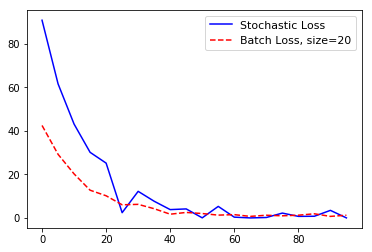

In [70]:
plt.plot(range(0, 100, 5), loss_stochastic, 'b-', label='Stochastic Loss')
plt.plot(range(0, 100, 5), loss_batch, 'r--', label='Batch Loss, size=20')
plt.legend(loc='upper right', prop={'size': 11})
plt.show()

---

# Combining Everything Together

This file will perform binary classification on the iris dataset. We will only predict if a flower is I.setosa or not. 

We will create a simple binary classifier by creating a line and running everything through a sigmoid to get a binary predictor. The two features we will use are pedal length and pedal width.  We use these two features because we know that Iris setosa is separable by these two features.  We aim to find the line that separates it out.

We will use batch training, but this can be easily adapted to stochastic training (i.e. set batch size equal to 1).

We start by loading the necessary libraries and resetting the computational graph.

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Load Iris Data

We load the data and mark the target if it is I. setosa or not.  The input data will be the 3rd and 4th features of the data set. (Petal Length and Petal Width).

In [72]:
# Load the iris data
# iris.target = {0, 1, 2}, where '0' is setosa
# iris.data ~ [sepal.width, sepal.length, pedal.width, pedal.length]
iris = datasets.load_iris()
binary_target = np.array([1. if x==0 else 0. for x in iris.target])
iris_2d = np.array([[x[2], x[3]] for x in iris.data])

We set the batch size to 20.

In [73]:
batch_size = 20

Then we start a computational graph session.

In [74]:
# Create graph
sess = tf.Session()

### Placeholders

We declare the placeholders for the model.  Just to illustrate that we can feed in multiple x-features separately, we create two separate placeholders for the two Iris features.

In [75]:
# Declare placeholders
x1_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x2_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

### Model Variables

We are going to be doing a linear model, so we will need to create two variables, `A` (slope) and `b` (intercept).

In [76]:
# Create variables A and b
A = tf.Variable(tf.random_normal(shape=[1, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

### Model Operations

A line can be defined as $x_{1}=A\cdot x_{2} + b$. To create a linear separator, we would like to see which side of the line the data points fall. There are three cases:

- A point exactly on the line will satisfy: $0 = x_{1} - (A\cdot x_{2} + b)$
- A point above the line satisfies: $0 > x_{1} - (A\cdot x_{2} + b)$
- A point below the line satisfies: $0 < x_{1} - (A\cdot x_{2} + b)$

We will make the output of this model:

$$x_{1} - (A \cdot x_{2} + b)$$

Then the predictions will be the sign of that output:

$$Prediction(x_{1},x_{2}) = sign(x_{1} - (A \cdot x_{2} + b))$$

So we add the corresponding operations to the computational graph.

In [77]:
# Add model to graph:
# x1 - A*x2 + b
my_mult = tf.matmul(x2_data, A)
my_add = tf.add(my_mult, b)
my_output = tf.subtract(x1_data, my_add)

### Loss Function

Since we are doing a categorical prediction (I.setosa or not), we will use the sigmoid cross entropy loss.  This is a function provided to us by TensorFlow.

In [78]:
# Add classification loss (cross entropy)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target)

### Optimizing Function and Variable Initialization

We use the standard Gradient Descent Optimization function with a learning rate of `0.05`.  We then add and run a variable initialization operation.

In [79]:
# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Run Classification

We run the classification for 1000 iterations and output the values of `A`, `b`, and loss every 200 iterations.

In [80]:
# Run Loop
for i in range(1000):
    rand_index = np.random.choice(len(iris_2d), size=batch_size)
    #rand_x = np.transpose([iris_2d[rand_index]])
    rand_x = iris_2d[rand_index]
    rand_x1 = np.array([[x[0]] for x in rand_x])
    rand_x2 = np.array([[x[1]] for x in rand_x])
    #rand_y = np.transpose([binary_target[rand_index]])
    rand_y = np.array([[y] for y in binary_target[rand_index]])
    sess.run(train_step, feed_dict={x1_data: rand_x1, x2_data: rand_x2, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ', b = ' + str(sess.run(b)))

Step #200 A = [[ 8.56491089]], b = [[-3.48949814]]
Step #400 A = [[ 10.11510563]], b = [[-4.67516184]]
Step #600 A = [[ 11.11963177]], b = [[-5.42355967]]
Step #800 A = [[ 11.79613113]], b = [[-5.96573877]]
Step #1000 A = [[ 12.35272503]], b = [[-6.38640738]]


### Visualize Results

We pull out the slope and intercept and plot the predictions

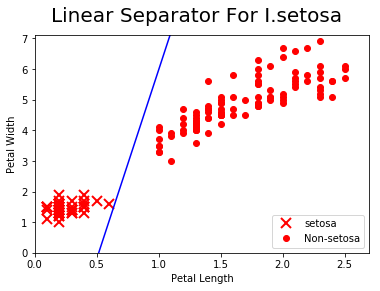

In [81]:
# Pull out slope/intercept
[[slope]] = sess.run(A)
[[intercept]] = sess.run(b)

# Create fitted line
x = np.linspace(0, 3, num=50)
ablineValues = []
for i in x:
  ablineValues.append(slope*i+intercept)

# Plot the fitted line over the data
setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==1]
setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==1]
non_setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==0]
non_setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==0]
plt.plot(setosa_x, setosa_y, 'rx', ms=10, mew=2, label='setosa')
plt.plot(non_setosa_x, non_setosa_y, 'ro', label='Non-setosa')
plt.plot(x, ablineValues, 'b-')
plt.xlim([0.0, 2.7])
plt.ylim([0.0, 7.1])
plt.suptitle('Linear Separator For I.setosa', fontsize=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc='lower right')
plt.show()

# Evaluating Models

This code will implement two models.  The first is a simple regression model, we will show how to call the loss function, MSE during training, and output it after for test and training sets.

The second model will be a simple classification model.  We will also show how to print percent classified for both the test and training sets.

### Regression Model

For the regression model we will generate 100 random samples from a Normal(mean=1, sd=0.1).  The target will be an array of size 100 filled with the target value of 10.0.

We will fit the linear model $y=A \cdot x$ (no y intercept).  The theoretical value of `A` is `10.0`.

To start we load the necessary libraries and reset the computational graph.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

Start a graph session:

In [83]:
sess = tf.Session()

Declare the batch size:

In [84]:
batch_size = 25

### Generate Data for Regression

Here we generate the data required for the regression.  We also specify the necessary placeholders.

After we split the data into a 80-20 train-test split.

In [85]:
# Create data
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### Model Variables and Operations

We create the model variable `A` and the multiplication operation.

In [86]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1,1]))

# Add operation to graph
my_output = tf.matmul(x_data, A)

### Loss, Optimization Function, and Variable Initialization

We use the L2 loss, and the standard Gradient Descent Optimization with a learning rate of 0.02.

In [87]:
# Add L2 loss operation to graph
loss = tf.reduce_mean(tf.square(my_output - y_target))

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Run Regression

We iterate 100 times through the training step, selecting a random batch of data each time.

In [88]:
# Run Loop
for i in range(100):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = np.transpose([x_vals_train[rand_index]])
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%25==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})))



Step #25 A = [[ 6.14475536]]
Loss = 15.6186
Step #50 A = [[ 8.61418819]]
Loss = 2.24975
Step #75 A = [[ 9.53450966]]
Loss = 1.05499
Step #100 A = [[ 9.85481644]]
Loss = 0.576763


### Evaluation of Regression Model

For the regression model evaluation, we will run the loss wih the training and test set.

In [89]:
# Evaluate accuracy (loss) on test set
mse_test = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_test]), y_target: np.transpose([y_vals_test])})
mse_train = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_train]), y_target: np.transpose([y_vals_train])})
print('MSE on test:' + str(np.round(mse_test, 2)))
print('MSE on train:' + str(np.round(mse_train, 2)))

MSE on test:1.11
MSE on train:0.82


# Classification Example

For the classification example, we generate data as follows:

The input data will be a sample of size 50 from a Normal(mean = -1, sd = 1) and a sample of 50 from a Normal(mean = 1, sd = 1).

The target data will be 50 values of 0 and 50 values of 1.

We fit the binary classification model:

- If $sigmoid(x+A)<0.5$ Then we predict class 0
- If $sigmoid(x+A)>=0.5$ Then we predict class 1

Theoretically A should be

$$ - \frac{mean1 + mean2}{2} = 0$$

We start by resetting the computational graph:

In [90]:
ops.reset_default_graph()

Create a graph session:

In [91]:
sess = tf.Session()

Declare the batch size:

In [92]:
batch_size = 25

### Generate Classification Data and Targets

We generate the classification data as described above.  Then we create the necessary placeholders.

After, we split the data in a 80-20 train-test split.

In [93]:
# Create data
x_vals = np.concatenate((np.random.normal(-1, 1, 50), np.random.normal(2, 1, 50)))
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50)))
x_data = tf.placeholder(shape=[1, None], dtype=tf.float32)
y_target = tf.placeholder(shape=[1, None], dtype=tf.float32)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### Model Variables and Operations

We create the model variable, `A`, and the model operation, which is the adding of `A` to the input data.  Note that we do not put the `sigmoid()` function in here because it will be included in the loss function.  This also means that for prediction, we will need to include the sigmoid function.

In [94]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(mean=10, shape=[1]))

# Add operation to graph
# Want to create the operstion sigmoid(x + A)
# Note, the sigmoid() part is in the loss function
my_output = tf.add(x_data, A)

### Loss, Optimization Function, and Variable Initialization

The loss will be the sigmoid-cross-entropy.  We wrap that function in a `tf.reduce_mean()` so that we can reduce the sigmoid-cross-entropy over the whole batch.

The optimization function we use is again the standard Gradient Descent Optimization with a learning rate of 0.05.

In [95]:
# Add classification loss (cross entropy)
xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target))

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Run Classification

We iterate the classification training operation for 1800 iterations and print off the `A` values along with the loss every 200 iterations

In [96]:
# Run loop
for i in range(1800):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = [x_vals_train[rand_index]]
    rand_y = [y_vals_train[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #200 A = [ 4.38810778]
Loss = 1.15902
Step #400 A = [ 0.47550225]
Loss = 0.36992
Step #600 A = [-0.55644304]
Loss = 0.353173
Step #800 A = [-0.75120735]
Loss = 0.272923
Step #1000 A = [-0.80024737]
Loss = 0.278264
Step #1200 A = [-0.80178905]
Loss = 0.318156
Step #1400 A = [-0.84598315]
Loss = 0.342722
Step #1600 A = [-0.85435754]
Loss = 0.285672
Step #1800 A = [-0.86995381]
Loss = 0.363045


### Evaluation of Classification Results

Accuracy on train set: 0.9375
Accuracy on test set: 0.85


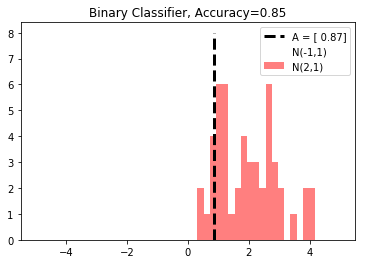

In [97]:
# Evaluate Predictions on test set
y_prediction = tf.squeeze(tf.round(tf.nn.sigmoid(tf.add(x_data, A))))
correct_prediction = tf.equal(y_prediction, y_target)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_value_test = sess.run(accuracy, feed_dict={x_data: [x_vals_test], y_target: [y_vals_test]})
acc_value_train = sess.run(accuracy, feed_dict={x_data: [x_vals_train], y_target: [y_vals_train]})
print('Accuracy on train set: ' + str(acc_value_train))
print('Accuracy on test set: ' + str(acc_value_test))

# Plot classification result
A_result = -sess.run(A)
bins = np.linspace(-5, 5, 50)
plt.hist(x_vals[0:50], bins, alpha=0.5, label='N(-1,1)', color='white')
plt.hist(x_vals[50:100], bins[0:50], alpha=0.5, label='N(2,1)', color='red')
plt.plot((A_result, A_result), (0, 8), 'k--', linewidth=3, label='A = '+ str(np.round(A_result, 2)))
plt.legend(loc='upper right')
plt.title('Binary Classifier, Accuracy=' + str(np.round(acc_value_test, 2)))
plt.show()